In [22]:
%matplotlib inline

In [23]:
import numpy as np
import scipy
import scipy.stats
import random
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 1. Make inference about underlying distributions

### (a) Number of isthmus clones per HF in dependence of labelling efficiency.

In [24]:
#upload empirical data

clones_per_HF_emp = pd.DataFrame(index = ['AS30:5','AS30:7','AS42:3','AS55:2','AS51:4','AS55:3'], columns = range(5))

clones_per_HF_emp.ix['AS30:5'] = [212,30,7,1,0]
clones_per_HF_emp.ix['AS30:7'] = [94,6,2,0,0]
clones_per_HF_emp.ix['AS42:3'] = [95,26,11,2,0]
clones_per_HF_emp.ix['AS55:2'] = [77,12,2,0,0]
clones_per_HF_emp.ix['AS51:4'] = [162,14,1,0,0]
clones_per_HF_emp.ix['AS55:3'] = [119,4,0,0,0]

In [25]:
#calculate mu and var for each measurement

clones_per_HF_par = pd.DataFrame(index = clones_per_HF_emp.index, columns = ['mean', 'variance'])

for ix in enumerate(clones_per_HF_emp.index):
     
    y = clones_per_HF_emp.ix[ix[1]]
    
    #define mu and sigma
    
    y_list = []
    
    for val in enumerate(y):
        y_list += [val[0]] * val[1]
    
    mu = np.mean(y_list)
    sigma = np.var(y_list)
    
    clones_per_HF_par.ix[ix[1]] = [mu, sigma]
    
print clones_per_HF_par

              mean    variance
AS30:5       0.188    0.232656
AS30:7  0.09803922   0.1276432
AS42:3   0.4029851   0.4943194
AS55:2   0.1758242   0.1888661
AS51:4  0.09039548  0.09352357
AS55:3  0.03252033  0.03146275


The values for $\mu$ and $\sigma$ clearly indicate a overdispersed Poisson function which can be modeled as Gamma mixture of Poisson distribution. $\sigma$ furthermore seems to scale in dependence of $\mu$.

In [26]:
#define linear function of sigma in dependence of mu without intercept

x_tmp = np.array(clones_per_HF_par['mean'])
y_tmp = np.array(clones_per_HF_par['variance'])

x_tmp = x_tmp[:,np.newaxis]

slope, _, _, _, = np.linalg.lstsq(x_tmp, y_tmp)

slope = slope[0]

print slope

1.20463192626


Intercept is small enough to be ignored. Therefore:

$\sigma = r * \mu = 1.2046 * \mu$

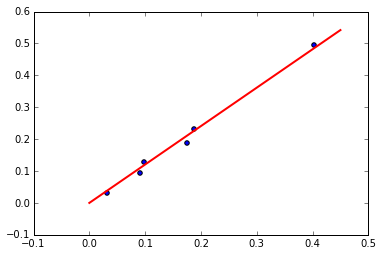

In [27]:
#plot regression line

plt.scatter(x_tmp, y_tmp)

plt.plot(np.arange(0, 0.5, 0.05), np.arange(0, 0.5, 0.05) * slope, linewidth = 2, color = 'r')

Gamma distributions are dependent on shape $k$ and scale $\theta$ and have a mean

$\mu = k\theta$

and a variance

$\sigma = k\theta(1+\theta)$;

therefore 

$k = \mu / (r-1)$

and 

$\theta = r - 1$

Problem: while this model represents mean and variance perfectly, the probability of n(isthmus clones) > 1 is much smaller compared to the empirical data.

Likely explanation: size constraints in the isthmus set a clear cutoff to the possible number of clones in the isthmus and thus make clone number distribution not perfectly modelable with a Gamma-Poisson function. A Gamma-Poisson model which perfectly represents the empirical probability of e.g. 1, 2, 3, 4 isthmus clones will have a higher variance than the empirical data since it contains a low probability of clone number sizes which are not possible in the empirical data due to size constraints mentioned above.

Workaround: while overstating the variance, a Gamma-Poisson model with

$k = \mu / r$

and 

$\theta = r$

better represents the empirical probabilities for clone numbers > 1.

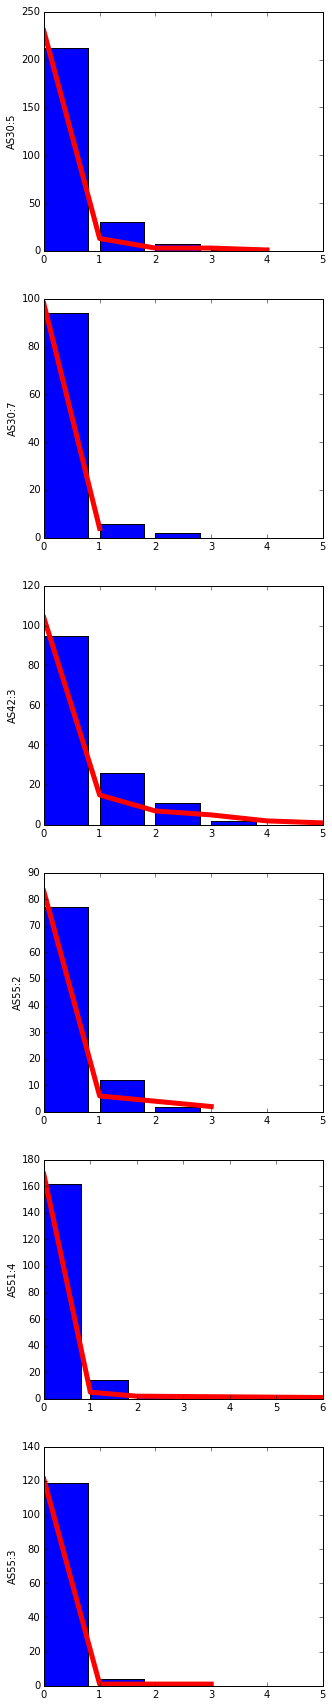

In [28]:
#plot empirical and sampled distribution and 

fig = plt.figure(facecolor = 'w', figsize = (5, 5 * len(clones_per_HF_emp.index)))

x = clones_per_HF_emp.columns

for ix in enumerate(clones_per_HF_emp.index):
    
    y = clones_per_HF_emp.ix[ix[1]]
        
    #plot bars
    
    ax = plt.subplot(len(clones_per_HF_emp.index),1,ix[0] + 1)
    
    ax.bar(x, y)
    
    ax.set_ylabel(ix[1])
    
    #define parameters for sampling
    
    n = clones_per_HF_emp.ix[ix[1]].sum()
    
    mu = clones_per_HF_par.ix[ix[1], 'mean']
    
    r = slope

    k = mu / r

    theta = r
    
    #sample and plot
    
    results_tmp = []

    for it in range(n):
    
        lam = np.random.gamma(k, theta)
    
        sample = np.random.poisson(lam)
    
        results_tmp.append(sample)
        
    results_tmp = Counter(results_tmp)
        
    ax.plot(results_tmp.keys(),
            results_tmp.values(),
            linewidth = 5, color = 'r')

### (b) HFs_per_IFE_clone

In [29]:
HFs_per_clone_emp = open('/Users/sijo/Documents/Lgr6_simulations/HFs_per_clone_tmp.txt','r').read().split()

In [30]:
HFs_per_clone_emp = [int(val) for val in HFs_per_clone_emp]

In [31]:
mu = np.mean(HFs_per_clone_emp)
var = np.var(HFs_per_clone_emp)

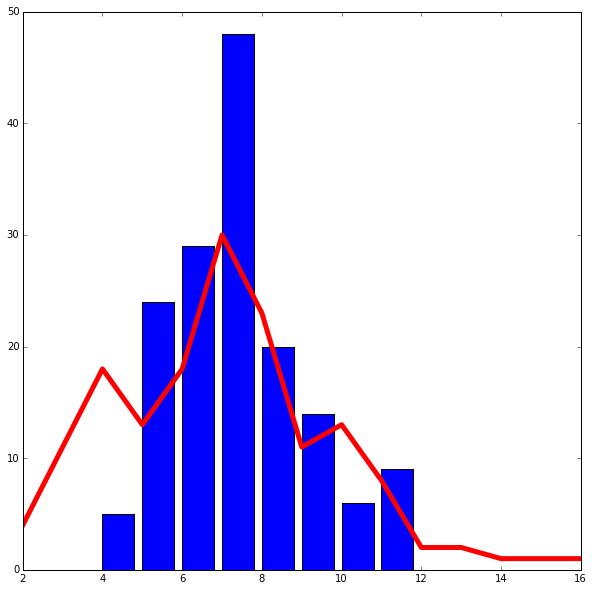

In [32]:
fig = plt.figure(facecolor = 'w', figsize = (10, 10))

ax = plt.subplot()

data_tmp = Counter(HFs_per_clone_emp)

ax.bar(data_tmp.keys(),
       data_tmp.values())

sim_tmp = Counter(np.random.poisson(mu, len(HFs_per_clone_emp)))

ax.plot(sim_tmp.keys(),
        sim_tmp.values(),
        linewidth = 5, color = 'red')

Although the real distribution seems underdispersed, using a Poisson function with $\lambda = \mu$ should suffice

# 2. Initialize functions

In [33]:
def Sim_CCC(label_eff_range, color_prob_IFE, color_prob_HF, iterations, clones_per_experiment, HFs_per_IFE_clone, 
            return_dict = False, dispersion_r = 1.20463192626):
    
    """
    Simulates IFE-IST clone color correlation defined as in Füllgrabe et al. 2F under the assumption that IFE 
    and IST populations are fully independent from each other and clone color in IFE and HF are the results 
    of a stochastic process.
    -----
    label_eff_range: np.arange [float, between 0.0 and 1.0] of label efficiencies.
    color_prob_IFE: dict containing IFE color probabilities [float, must add up to 1.0] for 'r', 'b', 'y', 'g'.
    color_prob_HF: dict containing HF color probabilities [float, must add up to 1.0] for 'r', 'b', 'y', 'g'.
    iterations: number [int] of experiment repeats.
    clones_per_experiment: number [int] of IFE-IST correlations analyzed per experiment.
    HFs_per_IFE_clone: average number [float] of HFs per clone.
    -----
    returns pd.DataFrame
    """
    
    #initialize results files 
    
    results = pd.DataFrame (index = ['corr', 'corr_2sigma', 
                                     'non_corr', 'non_corr_2sigma',
                                     'no_lab', 'no_lab_2sigma'], 
                            columns = label_eff_range)
    
    results_dict = {}
    
    #initialize color_choice as string of n colors proportional to color probability (4th decimal)
    
    color_choice_IFE = ''
    color_choice_HF = ''

    for key in color_prob_IFE:
    
        color_choice_IFE += key * int(color_prob_IFE[key] * 10000)
        
    for key in color_prob_HF:
        
        color_choice_HF += key * int(color_prob_HF[key] * 10000)
        
    #iterate through labeling efficiencies
    
    for label_eff in label_eff_range:
        
        #calculate parameters for Gamma distribution

        k = (label_eff / (dispersion_r)) + 0.000001 #added so that k always > 0

        theta = dispersion_r
        
        #initialize list of percentages for corr, non_corr and no_lab events
        
        corr, non_corr, no_lab = [], [], []
        
        #iterate through experiment repeats
        
        for it in range(iterations):
        
            #initialize counts of correlated, non_correlated and non-labelled repeats
    
            corr_count, non_corr_count, no_lab_count = 0,0,0
                
            #iterate throught number of analyzed IFE clones

            for IFE_clone in range(clones_per_experiment):
    
                IFE_c = random.choice(color_choice_IFE)
        
                HF_c = []
            
                #iterate through HF repeats ()
        
                for HF_rep in range(np.random.poisson(lam = HFs_per_IFE_clone)):
                
                    for clone_rep in range(np.random.poisson(lam = np.random.gamma(k, theta))):
                
                        HF_c.append(random.choice(color_choice_HF))
                    
                #increment either corr, non_corr or no_lab based on outcome of repeat
                
                if len(HF_c) == 0:
            
                    no_lab_count += 1
            
                elif IFE_c in HF_c:
                
                    corr_count += 1
                    
                else:
                
                    non_corr_count += 1
                    
            #calculate fractional values and update results
                
            corr.append(float(corr_count) / float(clones_per_experiment))
            non_corr.append(float(non_corr_count) / float(clones_per_experiment))
            no_lab.append(float(no_lab_count) / float(clones_per_experiment))
            
        #save raw data in results dict
        
        results_dict[label_eff] = {'corr':corr,'non_corr':non_corr,'no_lab':no_lab}
        
        #save means in results DataFrame
            
        results.ix['corr', label_eff] = np.mean(corr)
        results.ix['corr_2sigma', label_eff] = np.std(corr) * 2
        results.ix['non_corr', label_eff] = np.mean(non_corr)
        results.ix['non_corr_2sigma', label_eff] = np.std(non_corr) * 2
        results.ix['no_lab', label_eff] = np.mean(no_lab)
        results.ix['no_lab_2sigma', label_eff] = np.std(no_lab) * 2
            
    if return_dict == True:
        
        return results, results_dict
    
    else:
        
        return results

In [46]:
def drawSim_CCC(sim_results, emp_results = None):
    
    #create figure
    
    fig = plt.figure(facecolor = 'w', figsize = (14,10))
    ax0 = plt.axes()
    
    #create x-axis
    
    ax0.set_xlim(np.min(list(sim_results.columns)), np.max(list(sim_results.columns)))
    ax0.set_xticks(np.arange(np.min(list(sim_results.columns)), np.max(list(sim_results.columns)), 0.1))
    ax0.set_xticklabels(np.arange(np.min(list(sim_results.columns)), np.max(list(sim_results.columns)), 0.1), 
                        family = 'Arial', fontsize = 15)
    ax0.set_xlabel('Labelling efficieny', family = 'Arial', fontsize = 25)
    
    #create y-axis
    ax0.set_ylim(0.0, 1.0)
    ax0.set_yticks(np.arange(0.0, 1.01, 0.1))
    ax0.set_yticklabels(np.arange(0.0, 1.01, 0.1), family = 'Arial', fontsize = 15)
    ax0.set_ylabel('Probability', family = 'Arial', fontsize = 25)
    
    #plot correlated
    
    ax0.plot(sim_results.columns,
             sim_results.ix['corr'].values,
             linewidth = 3,
             color = 'red')
    
    #plot correlated 2 sigma fill
    
    ax0.fill_between(sim_results.columns,
                     [val for val in sim_results.ix['corr'] + sim_results.ix['corr_2sigma']],
                     [val for val in sim_results.ix['corr'] - sim_results.ix['corr_2sigma']],
                     color = 'red', alpha = 0.25)
    
    #plot non-correlated
    
    ax0.plot(sim_results.columns,
             sim_results.ix['non_corr'].values,
             linewidth = 3,
             color = 'green')
    
    #plot non-correlated 2 sigma fill
    
    ax0.fill_between(sim_results.columns,
                     [val for val in sim_results.ix['non_corr'] + sim_results.ix['non_corr_2sigma']],
                     [val for val in sim_results.ix['non_corr'] - sim_results.ix['non_corr_2sigma']],
                     color = 'green', alpha = 0.25)
    
    #plot no label
    
    ax0.plot(sim_results.columns,
             sim_results.ix['no_lab'].values,
             linewidth = 3,
             color = 'blue')
    
    ax0.fill_between(sim_results.columns,
                     [val for val in sim_results.ix['no_lab'] + sim_results.ix['no_lab_2sigma']],
                     [val for val in sim_results.ix['no_lab'] - sim_results.ix['no_lab_2sigma']],
                     color = 'blue', alpha = 0.25)
    
    #plot empirical datapoints
    
    if emp_results is not None:
        
        ax0.scatter(emp_results.columns, emp_results.ix['corr'], s = 250, color = 'red')
        ax0.scatter(emp_results.columns, emp_results.ix['non_corr'], s = 250, color = 'green')
        ax0.scatter(emp_results.columns, emp_results.ix['no_lab'], s = 250, color = 'blue')
        
    #plot labels
    
    ax0.text(np.max(list(sim_results.columns)) * 1.01,
             sim_results.ix['corr', np.max(list(sim_results.columns))],
             'Correlated', color = 'red', family = 'Arial', fontsize = 25, va = 'center')
    
    ax0.text(np.max(list(sim_results.columns)) * 1.01,
             sim_results.ix['non_corr', np.max(list(sim_results.columns))],
             'Non-correlated', color = 'green', family = 'Arial', fontsize = 25, va = 'center')
    
    ax0.text(np.max(list(sim_results.columns)) * 1.01,
             sim_results.ix['no_lab', np.max(list(sim_results.columns))],
             'No labeling', color = 'blue', family = 'Arial', fontsize = 25, va = 'center')

# 3. Load data

In [35]:
label_eff_range = np.arange(0.0, 1.01, 0.01)

In [36]:
color_prob_IFE = {'b':0.0510, 'r':0.4769, 'y':0.4179, 'g' : 0.0542}
color_prob_HF = {'b':0.0102, 'r':0.4569, 'y':0.4456, 'g':0.0873}

In [37]:
iterations = 100000

In [38]:
clones_per_experiment = 31

In [39]:
HFs_per_IFE_clone = 6.874058101

In [40]:
emp_results = pd.DataFrame(index = ['corr', 'non_corr', 'no_lab'])

emp_results[0.19] = [0.395348837,0.139534884,0.465116279]
emp_results[0.10] = [0.227272727,0.045454545,0.727272727]
emp_results[0.40] = [0.636363636,0.181818182,0.181818182]
emp_results[0.22] = [0.263157895,0.157894737,0.578947368]
emp_results[0.09] = [0.157894737,0.078947368,0.763157895]
emp_results[0.03] = [0.08,0.04,0.88]

# 3. Simulate and draw

In [41]:
sim_results = Sim_CCC(label_eff_range, color_prob_IFE, color_prob_HF, iterations, clones_per_experiment, HFs_per_IFE_clone, 
            return_dict = False)

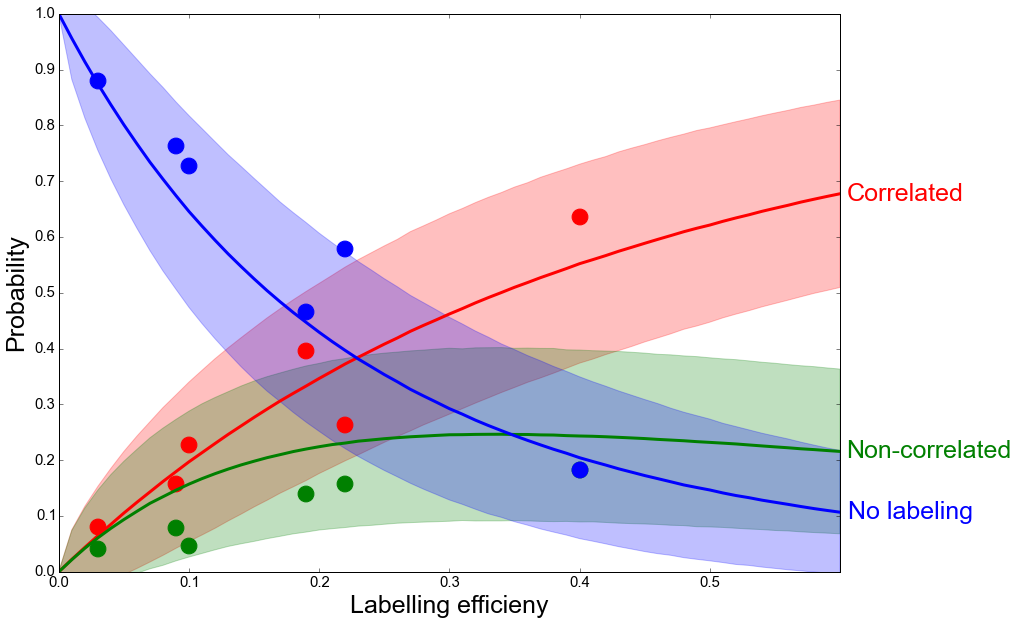

In [54]:
drawSim_CCC(sim_results[np.arange(0.0, 0.61, 0.01)], emp_results=emp_results)

In [43]:
#sim_results.to_csv(path_or_buf = 'IFE_correlation_sim_results.txt', sep = '\t')

In [63]:
results_show = pd.DataFrame (index = ['corr_emp', 'non_corr_emp', 'no_lab_emp','corr', 'corr_2sigma', 
                                     'non_corr', 'non_corr_2sigma',
                                     'no_lab', 'no_lab_2sigma'], 
                            columns = ['AS30:5','AS30:7','AS42:3','AS55:2','AS51:4','AS55:3'])

results_show['AS30:5']=list(emp_results[0.19]) + list(sim_results[0.19])
results_show['AS30:7']=list(emp_results[0.10]) + list(sim_results[0.10])
results_show['AS42:3']=list(emp_results[0.40]) + list(sim_results[0.40])
results_show['AS55:2']=list(emp_results[0.22]) + list(sim_results[0.22])
results_show['AS51:4']=list(emp_results[0.09]) + list(sim_results[0.09])
results_show['AS55:3']=list(emp_results[0.03]) + list(sim_results[0.03])

In [64]:
print results_show

                   AS30:5    AS30:7    AS42:3    AS55:2    AS51:4    AS55:3
corr_emp         0.395349  0.227273  0.636364  0.263158  0.157895  0.080000
non_corr_emp     0.139535  0.045455  0.181818  0.157895  0.078947  0.040000
no_lab_emp       0.465116  0.727273  0.181818  0.578947  0.763158  0.880000
corr             0.333039  0.197191  0.552214  0.372573  0.179564  0.064764
corr_2sigma      0.169423  0.142883  0.178243  0.173629  0.137469  0.088371
non_corr         0.220050  0.157191  0.243372  0.230743  0.146349  0.060841
non_corr_2sigma  0.148859  0.130730  0.154021  0.151397  0.126793  0.085687
no_lab           0.446911  0.645618  0.204414  0.396685  0.674087  0.874395
no_lab_2sigma    0.178851  0.171862  0.144961  0.176008  0.167916  0.119320
